# Credit Card Application Approval Prediction

## Project description

The goal is to predict whether a patient is likely to have a stroke given numerous health and 
living environmental factors:

- gender
- age
- hypertension
- heart_disease
- ever_married
- work_type
- Residence_type
- avg_glucose_level
- bmi
- smoking_status

## Library Imports

In [505]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix

## Import data

In [506]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

## Convert categorical data to numerical

In the data there are 5 columns with the catergorical values that need to be converted to numerical values.

- gender
- ever_married
- work_type
- Residence_type
- smoking_status

Additionally, there are 201 null cells in the "bmi" column that need to be converted.

In [507]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Convert the "gender" column

In [508]:
data['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [509]:
genders = {'Male':0, 'Female':1, 'Other':2}
data['gender'] = data['gender'].map(genders)

### Convert the "ever_married" column

In [510]:
data['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

In [511]:
married_status = {'No':0, 'Yes':1}
data['ever_married'] = data['ever_married'].map(married_status)

### Convert the "work_type" column

In [512]:
data['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [513]:
work_types = {'Private':0, 'Self-employed':1, 'Govt_job':2, 'children':3, 'Never_worked':4}
data['work_type'] = data['work_type'].map(work_types)

### Convert the "Residence_type" column

In [514]:
data['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [515]:
residence_types = {'Urban':0, 'Rural':1}
data['Residence_type'] = data['Residence_type'].map(residence_types)

### Convert the "smoking_status" column

In [516]:
data['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [517]:
smoking_statuses = {'formerly smoked':0, 'never smoked':1, 'smokes':2, 'Unknown':3}
data['smoking_status'] = data['smoking_status'].map(smoking_statuses)

### Convert nulls in the "bmi" column

In [518]:
print("Before:")
data['bmi'].head()

Before:


0    36.6
1     NaN
2    32.5
3    34.4
4    24.0
Name: bmi, dtype: float64

In [519]:
# convert null values to mean of non-nulls
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

print("After:")
data['bmi'].head()

After:


0    36.600000
1    28.893237
2    32.500000
3    34.400000
4    24.000000
Name: bmi, dtype: float64

### Re-check dataset to verify changes

In [520]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   int64  
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   int64  
 6   work_type          5110 non-null   int64  
 7   Residence_type     5110 non-null   int64  
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   int64  
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 479.2 KB


## Split data into training and testing sets

In [521]:
X = data[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
          'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']]
y = data['stroke']

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Exploring the data

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
ever_married         0.108340
bmi                  0.038947
id                   0.006388
gender              -0.009200
Residence_type      -0.015458
work_type           -0.058224
smoking_status      -0.066393
Name: stroke, dtype: float64

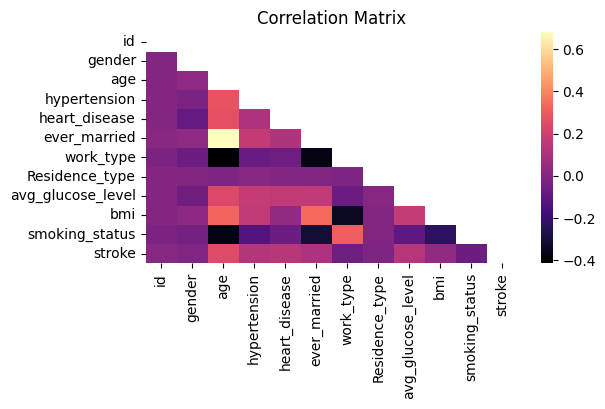

In [523]:
corr_matrix = data.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  
plt.figure(figsize=(6, 3))
sb.heatmap(corr_matrix, mask=mask, annot=False, lw=0, linecolor='white', cmap='magma', fmt='0.2f')
plt.title("Correlation Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

corr_matrix['stroke'].sort_values(ascending=False)  

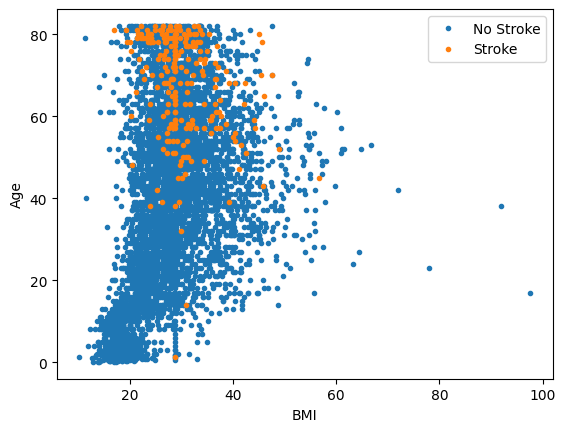

In [524]:
def plot_scatter_with_labels(X1, X2, Y, xlabel='BMI', ylabel='Age'):
  df = pd.DataFrame(dict(x1=X1, x2=X2, label=Y))
  groups = df.groupby('label')
  for number, group in groups:
    if number == 0:
      name = 'No Stroke'
    elif number == 1:
      name = 'Stroke'
    plt.plot(group.x1, group.x2, marker='o', linestyle='', ms=3, label=name)

  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

plot_scatter_with_labels(data['bmi'], data['age'], data['stroke'])

### Gender distribution

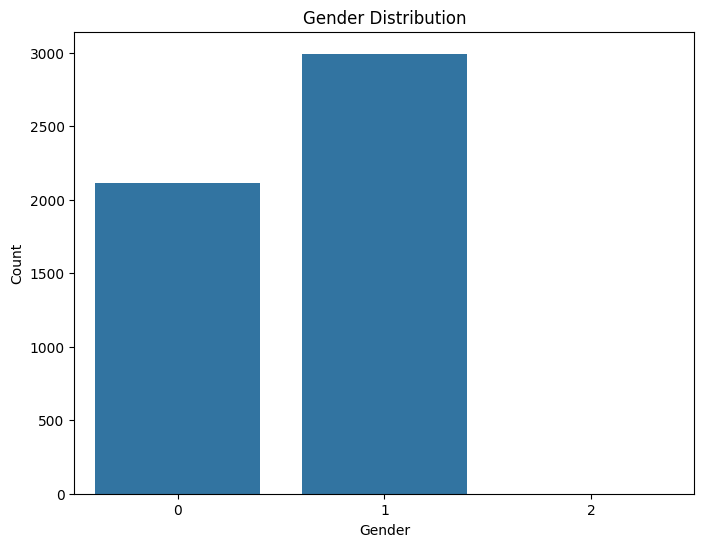

In [525]:
plt.figure(figsize=(8, 6))
sb.countplot(x='gender', data=data)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### Age distribution

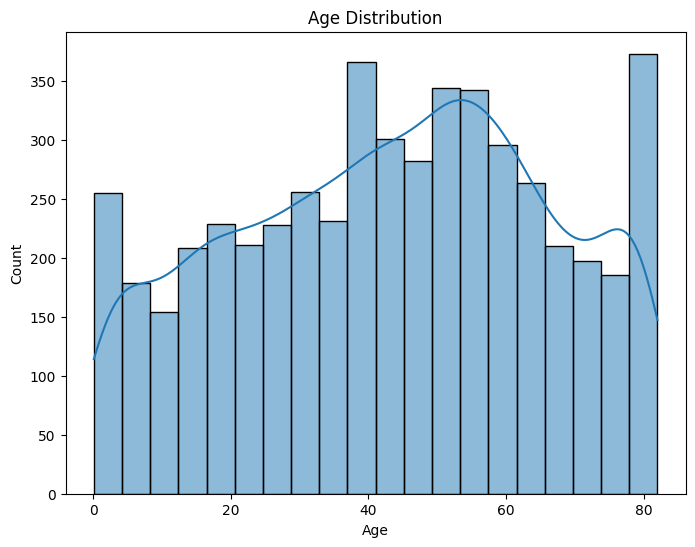

In [526]:
plt.figure(figsize=(8, 6))
sb.histplot(data['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Hypertension and heart disease

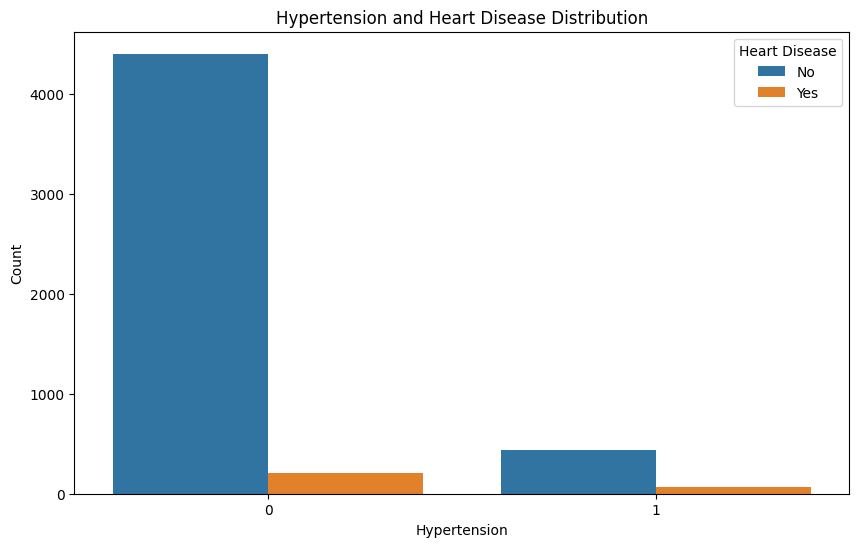

In [527]:
plt.figure(figsize=(10, 6))
sb.countplot(x='hypertension', hue='heart_disease', data=data)
plt.title('Hypertension and Heart Disease Distribution')
plt.xlabel('Hypertension')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.show()

### Glucose level and BMI

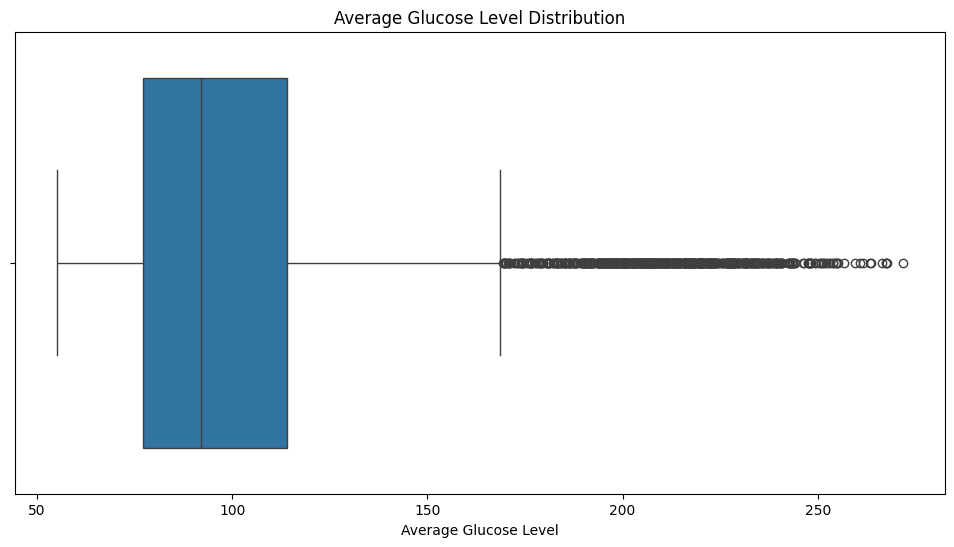

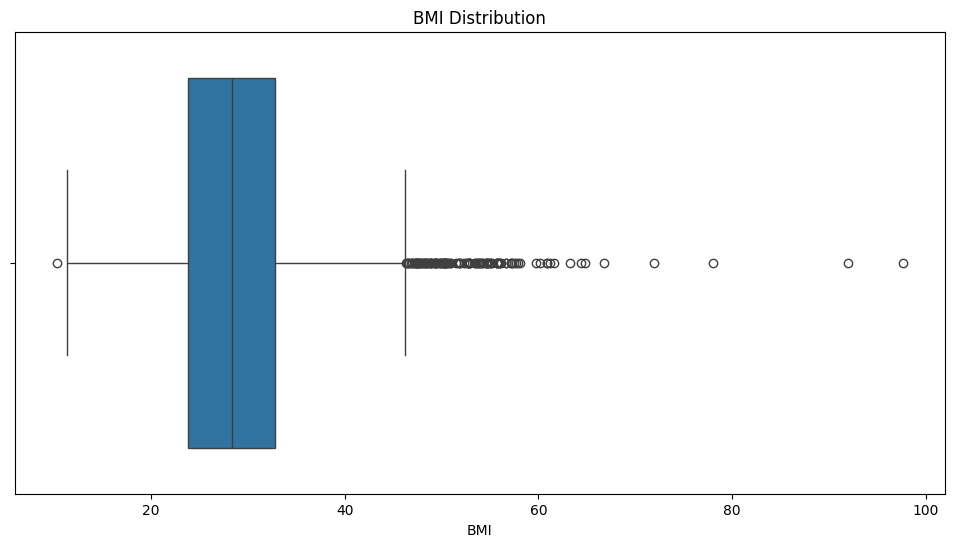

In [528]:
plt.figure(figsize=(12, 6))
sb.boxplot(x='avg_glucose_level', data=data)
plt.title('Average Glucose Level Distribution')
plt.xlabel('Average Glucose Level')
plt.show()

plt.figure(figsize=(12, 6))
sb.boxplot(x='bmi', data=data)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.show()

### Smoking status distribution

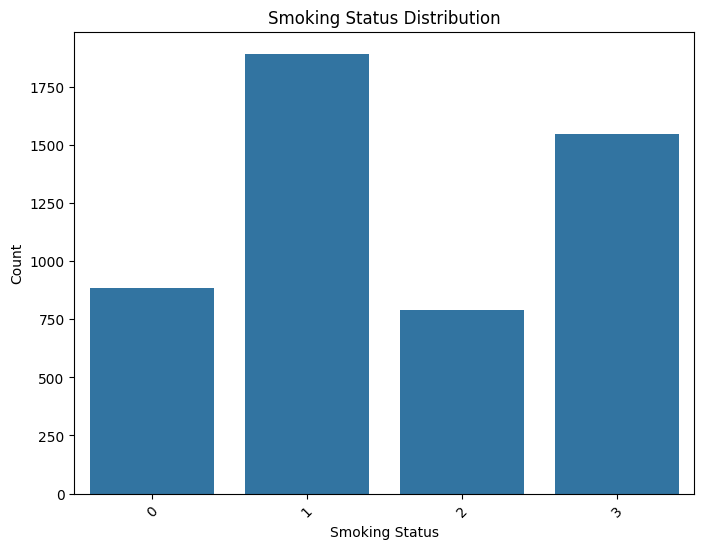

In [529]:
plt.figure(figsize=(8, 6))
sb.countplot(x='smoking_status', data=data)
plt.title('Smoking Status Distribution')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Stroke distribution

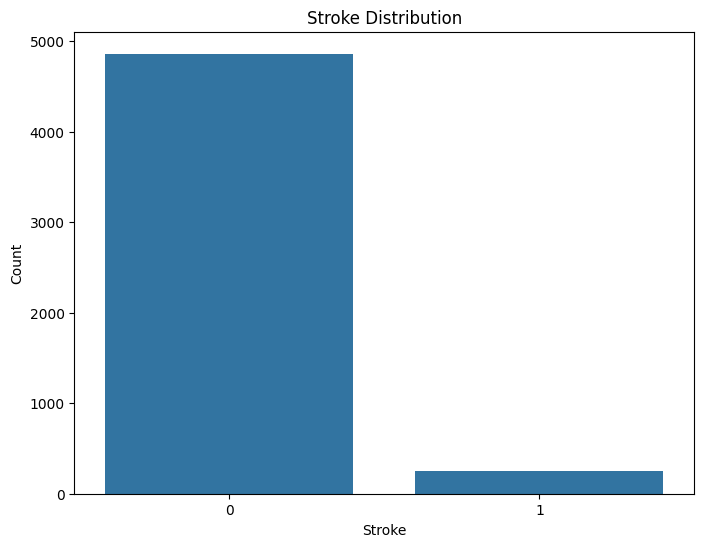

In [530]:
plt.figure(figsize=(8, 6))
sb.countplot(x='stroke', data=data)
plt.title('Stroke Distribution')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

## Data pre-processing

### Feature scaling

In [531]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Covert output to numpy array and adjust shape

In [532]:
y_train = y_train.to_numpy()
y_train = y_train.ravel()
y_test = y_test.to_numpy()
y_test = y_test.ravel()

## Testing different ML models

In [533]:
avg_cv_scores = {}

### Prepare plotting function

In [534]:
def plot_prediction_results(classifier, X_train, X_test, y_train, y_test):
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = classifier.predict(X_test)
    
    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Negative", "Positive"], rotation=45)
    plt.yticks(tick_marks, ["Negative", "Positive"])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### K-Nearst Neighbors (KNN)

[0.94987775 0.95232274 0.95232274 0.95104039 0.95471236]
Averaged prediction accuracy =  0.9520551962723663


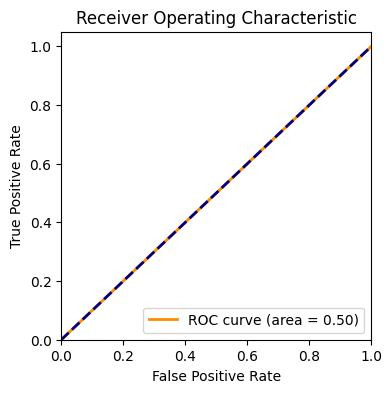

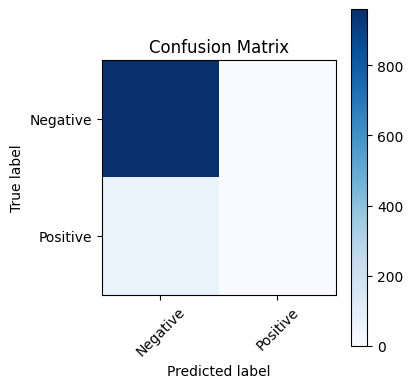

In [535]:
knn_clf = KNeighborsClassifier(n_neighbors=5) # change n_neighbors; boundary becomes smoother with increasing value of K
knn_clf.fit(X_train, y_train)
scores = cross_val_score(knn_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['KNN'] = np.average(scores)
plot_prediction_results(knn_clf, X_train, X_test, y_train, y_test)

### Naive Bayes

[0.86185819 0.88753056 0.85696822 0.85067319 0.86413709]
Averaged prediction accuracy =  0.8642334499465815


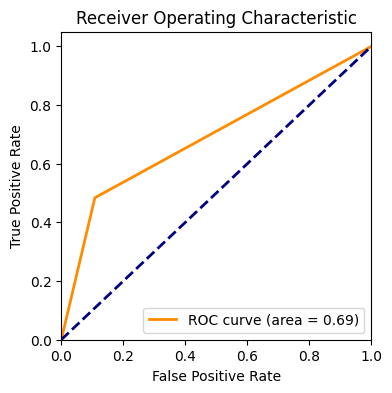

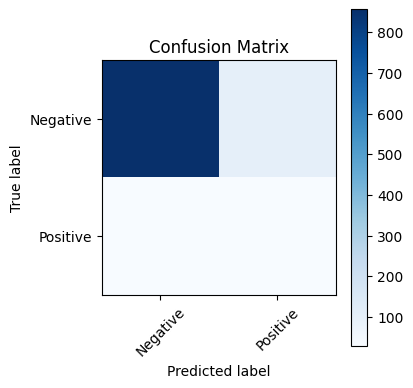

In [536]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
scores = cross_val_score(nb_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['NB'] = np.average(scores)
plot_prediction_results(nb_clf, X_train, X_test, y_train, y_test)

### Tree and Forest

[0.90464548 0.92787286 0.93154034 0.93512852 0.93268054]
Averaged prediction accuracy =  0.9263735474468284


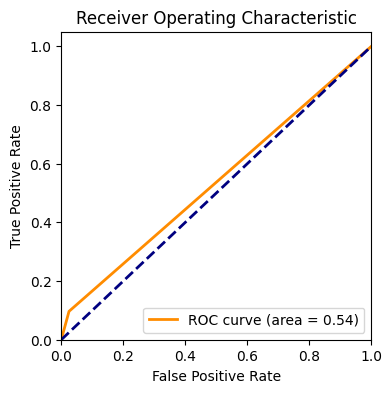

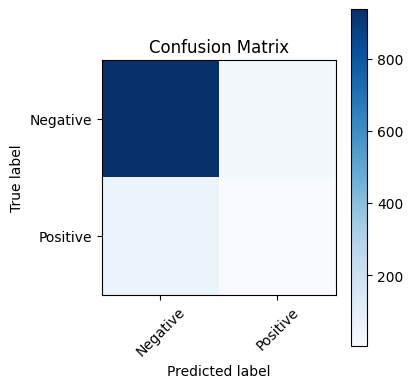

In [537]:
tree_clf = DecisionTreeClassifier(max_depth=10) # Play with hyperparameter
tree_clf.fit(X_train, y_train)
scores = cross_val_score(tree_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['Decision Tree'] = np.average(scores)
plot_prediction_results(tree_clf, X_train, X_test, y_train, y_test)

### SVM-linear

[0.95476773 0.95354523 0.95354523 0.95471236 0.95471236]
Averaged prediction accuracy =  0.9542565830622498


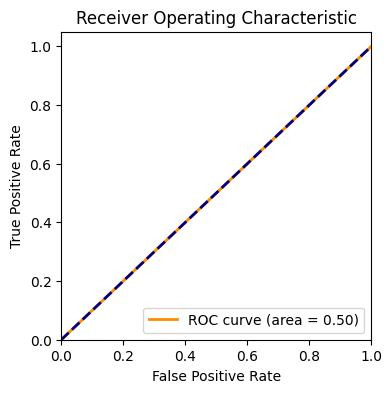

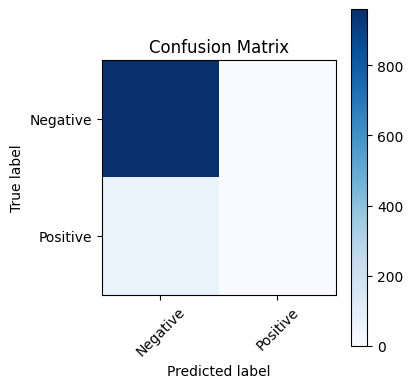

In [538]:
svmln_clf = SVC(kernel='linear')
svmln_clf.fit(X_train, y_train)
scores = cross_val_score(svmln_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['SVM-linear'] = np.average(scores)
plot_prediction_results(svmln_clf, X_train, X_test, y_train, y_test)

### SVM-nonlinear (RBF and POLY kernels)

#### RBF kernel

[0.95476773 0.95354523 0.95354523 0.95471236 0.95471236]
Averaged prediction accuracy =  0.9542565830622498


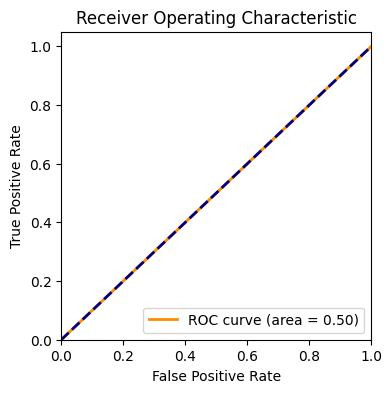

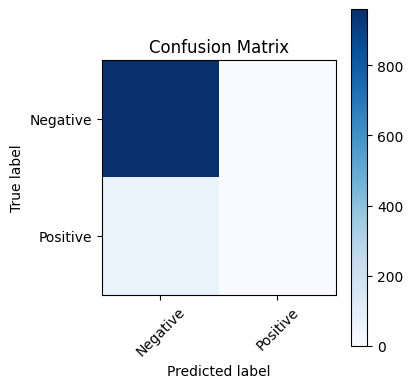

In [545]:
svmrbf_clf = SVC(kernel='rbf')
svmrbf_clf.fit(X_train, y_train)
scores = cross_val_score(svmrbf_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['SVM-nonlinear-rbf'] = np.average(scores)
plot_prediction_results(svmrbf_clf, X_train, X_test, y_train, y_test)

#### POLY kernel

[0.95232274 0.95354523 0.95476773 0.95348837 0.95104039]
Averaged prediction accuracy =  0.9530328921182811


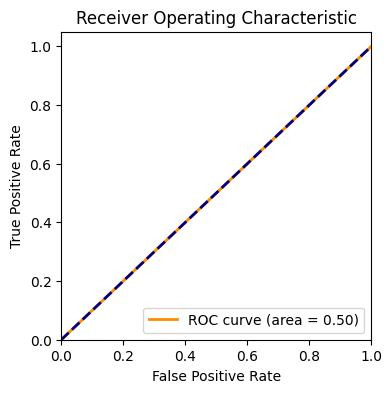

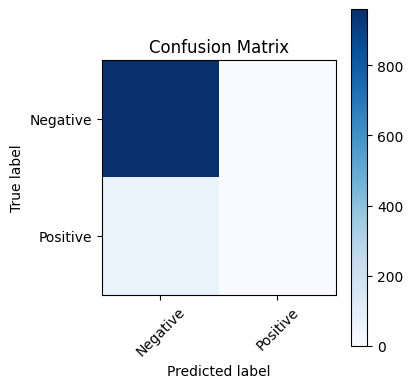

In [547]:
svmpoly_clf = SVC(kernel='poly')
svmpoly_clf.fit(X_train, y_train)
scores = cross_val_score(svmpoly_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['SVM-nonlinear-poly'] = np.average(scores)
plot_prediction_results(svmpoly_clf, X_train, X_test, y_train, y_test)

## Analysis and conlusion

### Using the trained models to get predictions on the test set

In [548]:
sorted_scores = sorted(avg_cv_scores.items(), key=lambda X:X[1], reverse=True)
print(sorted_scores)

[('SVM-linear', 0.9542565830622498), ('SVM-nonlinear-rbf', 0.9542565830622498), ('SVM-nonlinear-poly', 0.9530328921182811), ('KNN', 0.9520551962723663), ('Decision Tree', 0.9263735474468284), ('NB', 0.8642334499465815)]


In [549]:
test_pred_score = {}

In [552]:
# Naive Bayes Classifier
Y_test_pred_nb = nb_clf.predict(X_test)
test_pred_score['NB'] = accuracy_score(y_test, Y_test_pred_nb)

# K-Nearst Neighbors
Y_test_pred_knn = knn_clf.predict(X_test)
test_pred_score['KNN'] = accuracy_score(y_test, Y_test_pred_knn)

# Linear SVM
Y_test_pred_svmln = svmln_clf.predict(X_test)
test_pred_score['SVM_Linear'] = accuracy_score(y_test, Y_test_pred_svmln)

# Nonlinear SVM (RBF Kernel)
Y_test_pred_svmrbf = svmrbf_clf.predict(X_test)
test_pred_score['SVM_nonlinear-rbf'] = accuracy_score(y_test, Y_test_pred_svmrbf)

# Nonlinear SVM (POLY Kernel)
Y_test_pred_svmpoly = svmpoly_clf.predict(X_test)
test_pred_score['SVM_nonlinear-poly'] = accuracy_score(y_test, Y_test_pred_svmrbf)

# Decision Tree
Y_test_pred_tree_clf = tree_clf.predict(X_test)
test_pred_score['Decision Tree'] = accuracy_score(y_test, Y_test_pred_tree_clf)

In [553]:
sorted_scores = sorted(test_pred_score.items(), key=lambda X:X[1], reverse=True)
print(sorted_scores)

[('KNN', 0.9393346379647749), ('SVM_Linear', 0.9393346379647749), ('SVM_nonlinear', 0.9393346379647749), ('SVM_nonlinear-rbf', 0.9393346379647749), ('SVM_nonlinear-poly', 0.9393346379647749), ('Decision Tree', 0.9217221135029354), ('NB', 0.8669275929549902)]


### Analysis of results

As we can see here, the KNN model performs best on the test set

### Conclusion

Conclusion

## Reference

Dataset from: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset